In [251]:
import scipy.io
import os
import pandas as pd
import numpy as np
data=pd.read_csv('EEG_data_subject4', sep="\t") #loading data from dataset

In [252]:
df_imagined=pd.read_csv('EEG_data_subject3',sep="\t")
df_imagined.drop(["Time"],axis=1,inplace=True)

In [253]:
df_imagined

,F3,FC5,AF3,F7,T7,P7,O1,O2,P8,T8,F8,AF4,FC6,F4
0,0.0001,0.0001,0.0001,0.0006,0.0001,-0.0001,0.0001,-0.0002,0.0000,0.0001,0.0004,0.0002,0.0001,0.0002
1,-2.6005,109.7560,12.7059,-169.1160,-31.4479,-43.8039,-14.8167,74.4901,96.1760,43.1763,-72.2287,-23.7281,-7.7709,-11.0216
2,18.5243,-41.9819,-40.0490,-214.8748,-21.7062,22.3906,57.4387,126.8899,36.9631,-6.7186,-84.4190,5.1034,-1.1830,74.9133
3,-34.8816,-122.6321,-22.2373,-132.3502,36.5721,83.1185,23.8805,73.7514,3.3953,37.4902,-57.7188,69.9275,11.6359,-44.6514
4,-23.6387,-18.1475,40.6970,-69.2842,15.4405,36.3536,-23.5718,112.8957,45.0078,104.9738,-53.1022,-36.9185,-34.5765,-148.9800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255995,-23.7284,-31.5115,8.3845,-37.0174,45.9286,24.8491,-14.4279,-40.2837,17.8144,24.8574,-23.8540,37.8757,-45.3425,-8.0657
255996,6.0083,-3.0568,-14.2533,-42.4020,53.1407,9.1523,12.3190,16.3867,-20.4469,43.7724,-55.9562,-8.3505,-1.2869,-9.2040
255997,-21.4219,-13.4878,-7.7487,-42.2411,70.9432,41.9944,-11.5113,41.0238,-62.2157,-8.5281,-11.4892,-10.3153,29.9395,21.4559
255998,-17.8128,2.8300,5.0734,-34.6439,63.6781,75.0887,-69.4063,-26.0670,-5.7456,3.9624,9.9791,8.2445,6.6952,0.0593


In [254]:
df_inner=pd.read_csv('EEG_data_subject4',sep="\t")
df_inner.drop(["Time"],axis=1,inplace=True)
df_combined=pd.concat([df_imagined,df_inner])

In [370]:
data=np.array(df_imagined)
data=data.transpose()
data.shape
y_array=np.load("labels_word_list.npy")
# y_array=np.array(list(y_array)*2) --for combined data
y_array[:10]

array([14, 14, 14, 14, 14,  6,  6,  6,  6,  6])

In [372]:
num_dict={'date':0,'goose':1,'spruce':2,'knight':3,'juice':4,'moose':5,'night':6,'queen':7,'berry':8,'hedgehog':9,'water':10,'daughter':11,'gooseberry':12,'waterfowl':13,'wilderness':14,'relative':15,'watermelon':16,'caterpillar':17,'environment':18,'ambassador':19}

# Data Epoching

In [374]:
#epoching data by dividing by 256, a procedure in which specific time-windows are extracted from the continuous EEG signal
n=int(data.shape[1]/256)
epoched_data=[]
for i in range(n):
    epoched_data.append(data[:,256*i:256*(i+1)])
epoched_data=np.array(epoched_data)

In [376]:
p=np.random.RandomState(seed=42).permutation(len(y_array))
epoched_data==epoched_data[p]
y_array=y_array[p]
epoched_data.shape

(1000, 14, 256)

# Method Used to Augment Data

In [378]:
augmented_data=[]
n=epoched_data.shape[0]
length=128
overlap=32
for i in range(n):
    for j in range(0,length+1,overlap):
        augmented_data.append(epoched_data[i][:,j:j+length])
augmented_data=np.array(augmented_data)
augmented_data.shape

(5000, 14, 128)

In [379]:
epoched_data=augmented_data

In [380]:
new_array=[]
x=int(augmented_data.shape[0]/5000) #/1000 for 5000
for word in y_array:
    for i in range(x):
        new_array.append(word)
y_array=np.array(new_array)


In [381]:
# p = np.random.RandomState(seed=42).permutation(len(y_array))
# epoched_data = epoched_data[p]  # Correct: assignment
# y_array = y_array[p]

In [382]:
epoched_data.shape

(5000, 14, 128)

In [501]:
# Suppose you originally had 1000 trials in y_array
# Then you create 5000 augmented samples from those 1000
# You must replicate each label 5 times

augmented_labels = []
for label in y_array:
    for _ in range(5):  # or however many sub-trials you have per original
        augmented_labels.append(label)

y_array = np.array(augmented_labels)
print("y_array.shape:", y_array.shape)  # should now be (5000,)


y_array.shape: (5000,)


# Creating continuous data from epoched data

In [384]:
#creating continuous data from epoched data
continuous_data=[]
trials=epoched_data.shape[0]
channels=epoched_data.shape[1]
sample_size=epoched_data.shape[2]
for i in range(channels):
    continuous_data.append(epoched_data[:,i].reshape(trials*sample_size))
continuous_data=np.array(continuous_data)
continuous_data.shape


(14, 640000)

# Extracting alpha, beta, gamma bands from continuous data

In [386]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


Creating RawArray with float64 data, n_channels=14, n_times=640000
    Range : 0 ... 639999 =      0.000 ...  4999.992 secs
Ready.


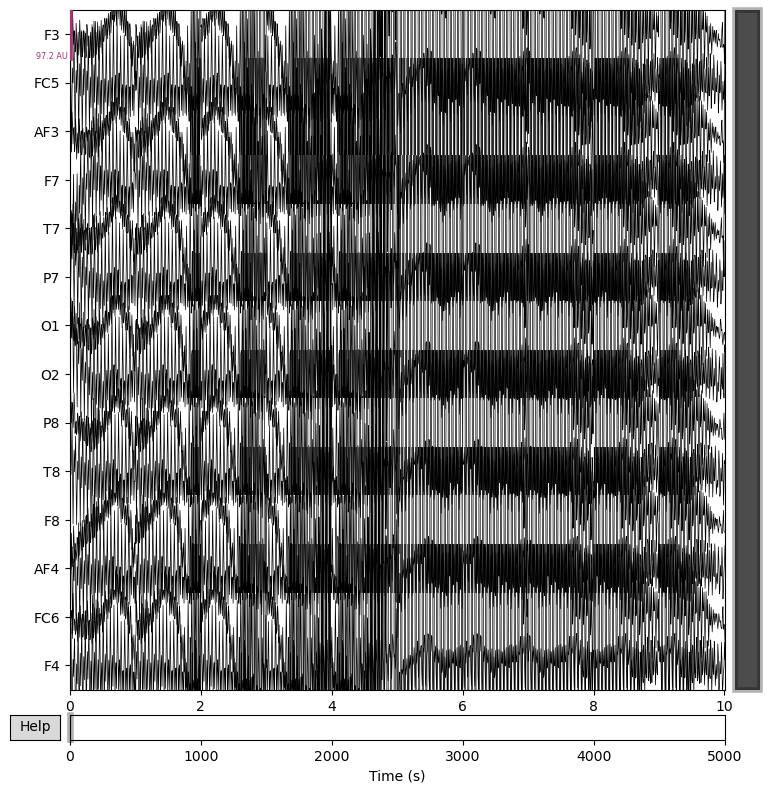

In [387]:
import mne
sfreq=128
ch_names=["F3","FC5","AF3","F7","T7","P7","O1","O2","P8","T8","F8","AF4","FC6","F4"] 
info=mne.create_info(ch_names,sfreq=sfreq)
raw=mne.io.RawArray(continuous_data,info)
raw.plot(scalings = 'auto');

# Filtering and downsampling

Plotting Power Spectral Density

In [390]:
# fig=raw.plot_psd(tmax=np.inf,average=True,picks='all')

Filtering

In [392]:
raw.notch_filter(60,picks='all')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)



<RawArray | 14 x 640000 (5000.0 s), ~68.4 MiB, data loaded>

Downsampling

In [394]:
# Downsample a lot
raw.resample(120, npad='auto')
# raw.compute_psd().plot(tmin=0, tmax=30, fmin=2, fmax=60, average=True, spatial_colors=False,picks='all');
# Notice that the max plotted frequency is 60, the nyquist rate!

<RawArray | 14 x 600000 (5000.0 s), ~64.1 MiB, data loaded>

In [395]:
alpha_continuous=mne.filter.filter_data(continuous_data,128,8,12)
beta_continuous=mne.filter.filter_data(continuous_data,128,12,30)
gamma_continuous=mne.filter.filter_data(continuous_data,128,30,50)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 s)

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- F

In [396]:
alpha_continuous.shape

(14, 640000)

In [397]:
#epoching all the frequency bands

trial_duration=epoched_data.shape[2] #trial duration
n=epoched_data.shape[0]
alpha_epoched=[]
beta_epoched=[]
gamma_epoched=[]
for i in range(n):
    alpha_epoched.append(alpha_continuous[:,i*trial_duration:(i+1)*trial_duration])
    beta_epoched.append(beta_continuous[:,i*trial_duration:(i+1)*trial_duration])
    gamma_epoched.append(gamma_continuous[:,i*trial_duration:(i+1)*trial_duration])
alpha_epoched=np.array(alpha_epoched)
beta_epoched=np.array(beta_epoched)
gamma_epoched=np.array(gamma_epoched)
    

In [398]:
alpha_epoched.shape

(5000, 14, 128)

# Feature Extraction Techniques

Type 1

Wavelet transform using PyWavelets is used as the first technique. PyWavelets is an open source
software used for wavelet transform in python. Retrieved statistical parameters including mean,
median, variance, skewness, and kurtosis as well as their first and second derivatives. As a
result, a feature vector for each channel is produced, which is then concatenated. The featurees are then standardized by removing the mean and scaling to
unit variance.

In [402]:
from pywt import wavedec
coeffs=wavedec(epoched_data,'db2',level=3)

In [403]:
def calc_features(arr):
    rms=np.sqrt(np.mean(arr**2,axis=2))
    var=np.var(arr,axis=2)
    kur=scipy.stats.kurtosis(arr,axis=2)
    skew=scipy.stats.skew(arr,axis=2)
    moment=scipy.stats.moment(arr,moment=3,axis=2)
    
    res=np.concatenate((rms,var,kur,skew,moment),axis=1)
    return res

In [404]:
coeffs.append(epoched_data)

In [405]:
res=[]
for arr in coeffs:
    res.append(calc_features(arr))

In [406]:
x_array_1=np.concatenate((res[0],res[1],res[2],res[3],res[4]),axis=1)

In [407]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(x_array_1)
x_array_1=scaler.transform(x_array_1)

In [408]:
x_array_1.shape

(5000, 350)

Type 2

In the second technique, the features,  mean phase coherence (MPC) is extracted along with magnitude-squared coherence (MSC) from the augmented data \citep{panachakel2021decoding}. MPC between two EEG channels is described as a measure of their phase synchronisation. The mean phase coherence (MPC) between two EEG signals with instantaneous phase difference $
    \phi(t)=\phi_1(t)-\phi_2(t)
$ can be estimated via,

$
    \lambda = \frac{1}{N}\Bigg|\sum_{n=0}^{N-1}e^{j(\hat{\phi}_i(n))}\Bigg|
$
where $
    {(\hat{\phi}_i(n))}_{n=0}^{N-1}
$ is the estimation of $
    \phi(t)
$,
where N is the number of samples,and the instantaneous phases are computed using Hilbert transform.
Where as, if a pair of signals are in spectral domain, MSC computes the linear relationship between them. Hamming window is used for this process. Let the auto-spectral densities and the cross-spectral density  of $
    x(t)
$ and $
    y(t)
$  be denoted by $
    P_{xx}(f)
$, $
    P_{yy}(f)
$  and $
    P_{xy}(f)
$ respectively at frequency f. The MSC between them is given by:

$
    \gamma _{xy}^{2} (f) = {{\left\vert {P_{xy} (f)} \right\vert^{2} } \over {P_{xx} (f)P_{yy} (f)}} 
$

Defining MSC and MPC

In [412]:
#calculation of hilbert array from augmented array
from scipy.signal import hilbert
from scipy.signal import welch
from scipy.signal import csd
#Defining magnitude squared coherence
import numpy as np
from scipy.signal import welch
from scipy.signal import csd,coherence
def msc(arr1,arr2):
    msc=coherence(arr1,arr2,fs=128,window="hamm",nperseg=8)[1]
    return np.mean(msc)

In [413]:
#Defining mean phase coherence
from scipy.signal import hilbert
import numpy as np
def mpc(arr1,arr2):
    
#     x_m = np.ma.array(arr1, mask=(x==0))
#     y_m = np.ma.array(arr2, mask=(y==0))
    imag_1=np.imag(hilbert(arr1))
    imag_2=np.imag(hilbert(arr2))
    phase_1=np.arctan(np.divide(imag_1, arr1, out=np.zeros_like(imag_1), where=arr1!=0))
    phase_2=np.arctan(np.divide(imag_2, arr2, out=np.zeros_like(imag_2), where=arr2!=0))
#     phase_1=np.arctan(imag_1/arr1)
#     phase_2=np.arctan(imag_2/arr2)
    phase_diff=(phase_1-phase_2)
    mpc=np.linalg.norm(np.sum(np.exp(1j*phase_diff)))/len(arr1)
    return mpc

In [414]:
n=alpha_epoched.shape[0]
m=alpha_epoched.shape[1]
l=alpha_epoched.shape[2]

mpc_alpha=np.zeros([n,m,m])
mpc_beta=np.zeros([n,m,m])
mpc_gamma=np.zeros([n,m,m])

msc_alpha=np.zeros([n,m,m])
msc_beta=np.zeros([n,m,m])
msc_gamma=np.zeros([n,m,m])

print(mpc_gamma.shape)


(5000, 14, 14)


In [415]:
for i in range(n):
    for j in range(m):
        for k in range(m):
            mpc_alpha[i][j][k]=mpc(alpha_epoched[i][j],alpha_epoched[i][k])
            msc_alpha[i][j][k]=msc(alpha_epoched[i][j],alpha_epoched[i][k])
            
            mpc_beta[i][j][k]=mpc(beta_epoched[i][j],beta_epoched[i][k])
            msc_beta[i][j][k]=msc(beta_epoched[i][j],beta_epoched[i][k])
            
            mpc_gamma[i][j][k]=mpc(gamma_epoched[i][j],gamma_epoched[i][k])
            msc_gamma[i][j][k]=msc(gamma_epoched[i][j],gamma_epoched[i][k])
    print(i,end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [416]:
mpc_alpha_copy=mpc_alpha
mpc_beta_copy=mpc_beta
mpc_gamma_copy=mpc_gamma

msc_alpha_copy=msc_alpha
msc_beta_copy=msc_beta
msc_gamma_copy=msc_gamma

In [417]:
msc_alpha_copy.shape

(5000, 14, 14)

In [418]:
mpc_alpha_copy.shape

(5000, 14, 14)

In [419]:
files=[mpc_alpha,mpc_beta,mpc_gamma,msc_alpha,msc_beta,msc_gamma]
file_names=["mpc_alpha","mpc_beta","mpc_gamma","msc_alpha","msc_beta","msc_gamma"]

In [420]:
part="01"
file_type="inner"
aug_type="non-aug"

In [421]:

#saving the files
for i in range(len(files)):
    path=''+part+'/'+part+'_'+file_type+'/'+aug_type+'/'+file_names[i]+'.npy'
    np.save(path,files[i])

In [422]:
#loading the files
for i in range(len(files)):
    path=''+part+'/'+part+'_'+file_type+'/'+aug_type+'/'+file_names[i]+'.npy'
    files[i]=np.load(path)

In [423]:
mpc_alpha=files[0]
mpc_beta=files[1]
mpc_gamma=files[2]

msc_alpha=files[3]
msc_beta=files[4]
msc_gamma=files[5]

In [424]:
msc_alpha.shape

(5000, 14, 14)

In [425]:
mpc_alpha.shape

(5000, 14, 14)

This section is used to create the feature vector

In [427]:
n_1=msc_alpha.shape[0]
m_1=msc_alpha.shape[1]
x_array_2=np.zeros([n_1,m_1,m_1,3])
print("mpc_alpha shape:", mpc_alpha.shape)
print("mpc_beta shape:", mpc_beta.shape)
print("mpc_gamma shape:", mpc_gamma.shape)

print("msc_alpha shape:", msc_alpha.shape)
print("msc_beta shape:", msc_beta.shape)
print("msc_gamma shape:", msc_gamma.shape)


mpc_alpha shape: (5000, 14, 14)
mpc_beta shape: (5000, 14, 14)
mpc_gamma shape: (5000, 14, 14)
msc_alpha shape: (5000, 14, 14)
msc_beta shape: (5000, 14, 14)
msc_gamma shape: (5000, 14, 14)


In [428]:
for i in range(n_1):
    for j in range(m_1):
        for k in range(m_1):
            if j<k:
                x_array_2[i][j][k]=[mpc_alpha[i][j][k],mpc_beta[i][j][k],mpc_gamma[i][j][k]]
            elif j>k:
                x_array_2[i][j][k]=[msc_alpha[i][j][k],msc_beta[i][j][k],msc_gamma[i][j][k]]

In [429]:
x_array_cnn=x_array_2

In [430]:
a=x_array_2.reshape(n_1,m_1*m_1*3)
a=a[a!=0.0]
a.shape
x_array_2=a.reshape(n_1,m_1*m_1*3-m_1*3)

In [431]:
x_array_2.shape

(5000, 546)

In [432]:
np.save(''+part+'/'+part+'_'+file_type+'_'+"X",x_array_2)
np.save(''+part+'/'+part+'_'+file_type+'_'+"Y",y_array)

In [433]:
x_array=np.load(''+part+'/'+part+'_'+file_type+'_'+"X"+".npy")
y_array=np.load(''+part+'/'+part+'_'+file_type+'_'+"Y"+".npy")

In [434]:
x_array = x_array_2

In [435]:
x_array.shape

(5000, 546)

In [436]:
y_array=np.load("labels_word_list.npy")
print(y_array)
if len(x_array)==2000:
    y_array=np.array(list(y_array)*2) #for combined data
    
# y_array=np.array(list(y_array)*2) --for combined data
y_array.shape

[14 14 14 14 14  6  6  6  6  6  1  1  1  1  1 13 13 13 13 13 15 15 15 15
 15 16 16 16 16 16  2  2  2  2  2  5  5  5  5  5 18 18 18 18 18 19 19 19
 19 19  9  9  9  9  9  8  8  8  8  8 17 17 17 17 17 11 11 11 11 11  3  3
  3  3  3  0  0  0  0  0  4  4  4  4  4  7  7  7  7  7 12 12 12 12 12 10
 10 10 10 10  6  6  6  6  6 12 12 12 12 12 18 18 18 18 18 17 17 17 17 17
  8  8  8  8  8  0  0  0  0  0  4  4  4  4  4  1  1  1  1  1 19 19 19 19
 19  5  5  5  5  5 10 10 10 10 10 13 13 13 13 13  9  9  9  9  9 15 15 15
 15 15  7  7  7  7  7 11 11 11 11 11 14 14 14 14 14  3  3  3  3  3  2  2
  2  2  2 16 16 16 16 16  4  4  4  4  4 12 12 12 12 12 10 10 10 10 10 17
 17 17 17 17 13 13 13 13 13  0  0  0  0  0 16 16 16 16 16 19 19 19 19 19
  7  7  7  7  7  1  1  1  1  1  5  5  5  5  5  2  2  2  2  2  6  6  6  6
  6 18 18 18 18 18  8  8  8  8  8 15 15 15 15 15  9  9  9  9  9  3  3  3
  3  3 11 11 11 11 11 14 14 14 14 14 13 13 13 13 13  2  2  2  2  2 10 10
 10 10 10  3  3  3  3  3 14 14 14 14 14  0  0  0  0

(1000,)

Reshape x_array for a “Single Time-Step” Transformer

In [438]:
import numpy as np

N, F = x_array.shape
seq_len = 1
input_dim = F

# Reshape from (N, F) -> (N, 1, F)
X_seq = x_array.reshape(N, seq_len, input_dim)

print("X_seq shape:", X_seq.shape)  # (N, 1, F)


X_seq shape: (5000, 1, 546)


In order to reduce the dimension of the feature vector Principal component analysis (PCA) was used. 

# Principal component analysis

In [441]:
from sklearn.decomposition import PCA
pca=PCA(.95)
pca.fit(x_array)
x_array=pca.transform(x_array)

In [497]:
x_array.shape

(5000, 110)

In [499]:
y_array.shape

(1000,)

# Build a PyTorch Dataset & DataLoader

In [444]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [503]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGCoherenceDataset(Dataset):
    def __init__(self, X, y):
        """
        X shape: (num_samples, seq_len, input_dim)
        y shape: (num_samples,)
        """
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y), "Mismatch in samples"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = self.X[idx]  # shape: (seq_len, input_dim)
        y_item = self.y[idx]  # single integer label
        # Convert to torch tensors
        x_item = torch.tensor(x_item, dtype=torch.float32)
        y_item = torch.tensor(y_item, dtype=torch.long)
        return x_item, y_item

# Create dataset
dataset = EEGCoherenceDataset(X_seq, y_array)

# Train/val/test split
num_samples = len(dataset)
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_size = int(0.8 * num_samples)
val_size   = int(0.1 * num_samples)
test_size  = num_samples - train_size - val_size

train_idx = indices[:train_size]
val_idx   = indices[train_size : train_size+val_size]
test_idx  = indices[train_size+val_size:]

X_train, y_train = X_seq[train_idx], y_array[train_idx]
X_val,   y_val   = X_seq[val_idx],   y_array[val_idx]
X_test,  y_test  = X_seq[test_idx],  y_array[test_idx]

train_ds = EEGCoherenceDataset(X_train, y_train)
val_ds   = EEGCoherenceDataset(X_val,   y_val)
test_ds  = EEGCoherenceDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")


Train size: 4000 | Val size: 500 | Test size: 500


Small Transformer Model

Here’s a light version of the code you saw earlier, but with logs. Note that seq_len=1 means we basically do a single “time step” pass, so the Transformer encoder is effectively operating on length 1. This is almost like an MLP—but it satisfies your professor’s requirement to use a “prediction model” (Transformer code path).

In [505]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class SmallTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, num_classes=5, dropout=0.1, pool="mean"):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = pool
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len=1, input_dim)
        returns: (batch_size, num_classes)
        """
        # 1) Embed
        x_embed = self.embedding(x)             # => (batch_size, seq_len, d_model)
        # 2) Positional Encoding
        x_pe = self.pos_encoder(x_embed)        # => (batch_size, seq_len, d_model)
        # 3) Transformer Encoder
        enc_out = self.transformer_encoder(x_pe)# => (batch_size, seq_len, d_model)
        
        # 4) Pool
        if self.pool == "mean":
            # But seq_len=1 => mean or last is same
            pooled = enc_out.mean(dim=1)        # => (batch_size, d_model)
        else:
            pooled = enc_out[:, -1, :]         # => (batch_size, d_model)

        # 5) Classify
        logits = self.classifier(pooled)        # => (batch_size, num_classes)
        return logits

print("Transformer code loaded successfully!")


Transformer code loaded successfully!


Training & Logging

In [539]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

num_classes = 20  # or the actual number of distinct words you have
model = SmallTransformer(
    input_dim=input_dim,  # e.g. F after PCA
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    num_classes=num_classes,
    dropout=0.1,
    pool="mean"
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 500 # Efficiency has 35%
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Evaluate on val
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)
            preds = logits.argmax(dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(batch_y.cpu().numpy())

    val_acc = accuracy_score(val_true, val_preds)
    print(f"[Epoch {epoch}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")


Using device: cpu
[Epoch 1/500] Train Loss: 3.0390 | Val Acc: 0.0500
[Epoch 2/500] Train Loss: 3.0189 | Val Acc: 0.0600
[Epoch 3/500] Train Loss: 3.0056 | Val Acc: 0.0680
[Epoch 4/500] Train Loss: 2.9846 | Val Acc: 0.0700
[Epoch 5/500] Train Loss: 2.9738 | Val Acc: 0.0640
[Epoch 6/500] Train Loss: 2.9536 | Val Acc: 0.0600
[Epoch 7/500] Train Loss: 2.9540 | Val Acc: 0.0860
[Epoch 8/500] Train Loss: 2.9457 | Val Acc: 0.0600
[Epoch 9/500] Train Loss: 2.9362 | Val Acc: 0.0620
[Epoch 10/500] Train Loss: 2.9218 | Val Acc: 0.0460
[Epoch 11/500] Train Loss: 2.9121 | Val Acc: 0.0720
[Epoch 12/500] Train Loss: 2.9001 | Val Acc: 0.0940
[Epoch 13/500] Train Loss: 2.8954 | Val Acc: 0.0740
[Epoch 14/500] Train Loss: 2.8780 | Val Acc: 0.0920
[Epoch 15/500] Train Loss: 2.8619 | Val Acc: 0.1020
[Epoch 16/500] Train Loss: 2.8514 | Val Acc: 0.1160
[Epoch 17/500] Train Loss: 2.8330 | Val Acc: 0.1000
[Epoch 18/500] Train Loss: 2.8142 | Val Acc: 0.0700
[Epoch 19/500] Train Loss: 2.7887 | Val Acc: 0.1080
[Ep

Test Accuracy: 0.358


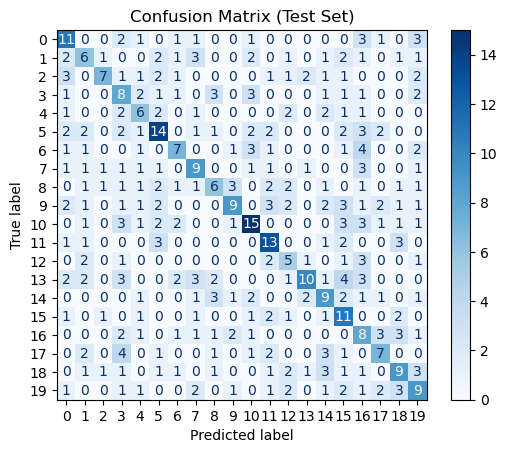

In [540]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        logits = model(batch_x)
        preds = logits.argmax(dim=-1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(batch_y.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print("Test Accuracy:", test_acc)

cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.show()


# Retrieve Predicted Labels for Each Sample


In [542]:
import torch

model.eval()
all_predictions = []
all_true_labels = []
all_sample_indices = []  # optional: track which sample index

with torch.no_grad():
    for batch_idx, (batch_x, batch_y) in enumerate(test_loader):
        # batch_x shape: (batch_size, seq_len, input_dim)
        # batch_y shape: (batch_size,)
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        logits = model(batch_x)  # => shape (batch_size, num_classes)
        preds = logits.argmax(dim=-1)  # => shape (batch_size,)

        # Convert to CPU numpy arrays
        preds_np = preds.cpu().numpy()
        labels_np = batch_y.cpu().numpy()

        # Store results
        all_predictions.extend(preds_np)
        all_true_labels.extend(labels_np)

        # If you want to track the test sample index:
        start_idx = batch_idx * test_loader.batch_size
        sample_indices = range(start_idx, start_idx + len(batch_y))
        all_sample_indices.extend(sample_indices)

# Now all_predictions[i] corresponds to the predicted label for sample i
# all_true_labels[i] is the ground-truth label for sample i


# Mapping Labels Back to Words (Optional)

In [544]:
label2word = {v: k for k, v in num_dict.items()}


for i in range(len(all_predictions)):
    pred_label = all_predictions[i]
    true_label = all_true_labels[i]
    pred_word = label2word[pred_label]
    true_word = label2word[true_label]
    # print(f"Sample {i}: Predicted '{pred_word}', Actual '{true_word}'")

correct_predictions = sum(1 for i in range(len(all_predictions)) if all_predictions[i] == all_true_labels[i])
total_predictions = len(all_predictions)

accuracy = correct_predictions / total_predictions
print(f"Total Correct: {correct_predictions}/{total_predictions} ({accuracy * 100:.2f}%)")



Total Correct: 179/500 (35.80%)


# Storing Results to a CSV or TXT File

In [549]:
import csv

with open("predictions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["SampleIndex", "PredLabel", "TrueLabel", "PredWord", "TrueWord"])

    for i in range(len(all_predictions)):
        pred_label = all_predictions[i]
        true_label = all_true_labels[i]
        pred_word = label2word[pred_label]
        true_word = label2word[true_label]

        # If you tracked sample indices:
        sample_idx = all_sample_indices[i]
        writer.writerow([sample_idx, pred_label, true_label, pred_word, true_word])


# Classifiers

Modelling RF

In [552]:
from collections import Counter
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [553]:
def model_rf(x_train,y_train,x_test,y_test):
    random=RandomForestClassifier()
    distributions=dict(max_depth=[2,3,4],n_estimators=[10,20,30,40,50],criterion=['gini'],random_state=[42])
    clf=GridSearchCV(random,distributions,cv=2)
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_acc=accuracy_score(y_train,y_pred_train)
    test_acc=accuracy_score(y_test,y_pred_test)
    return train_acc,test_acc
    
    

In [554]:
def model_rf1(x_train,y_train,x_test,y_test):
    random=RandomForestClassifier()
    distributions=dict(max_depth=[2,3,4],n_estimators=[10,20,30,40,50],criterion=['gini'],random_state=[42])
    clf=GridSearchCV(random,distributions,cv=2)
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_f1Score=metrics.f1_score(y_train,y_pred_train,average='weighted',zero_division=1)
    test_f1Score=metrics.f1_score(y_test,y_pred_test,average='weighted',zero_division=1)
    #recall_score
    train_recallScore=metrics.recall_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_recallScore=metrics.recall_score(y_test,y_pred_test, average='weighted', zero_division=1)  
    #precision_score
    train_precisionScore=metrics.precision_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_precisionScore=metrics.precision_score(y_test,y_pred_test, average='weighted', zero_division=1) 
    return train_f1Score,test_f1Score,test_recallScore,test_precisionScore


Modelling SVM

In [556]:
def model_svm(x_train,y_train,x_test,y_test):
    clf=svm.SVC(kernel='rbf')
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_acc=accuracy_score(y_train,y_pred_train)
    test_acc=accuracy_score(y_test,y_pred_test)
    return train_acc,test_acc

In [557]:
def model_svm1(x_train,y_train,x_test,y_test):
    clf=svm.SVC(kernel='rbf')
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_f1Score=metrics.f1_score(y_train,y_pred_train,average='weighted',zero_division=1)
    test_f1Score=metrics.f1_score(y_test,y_pred_test,average='weighted',zero_division=1)
    #recall_score
    train_recallScore=metrics.recall_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_recallScore=metrics.recall_score(y_test,y_pred_test, average='weighted', zero_division=1)
    #precision_score
    train_precisionScore=metrics.precision_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_precisionScore=metrics.precision_score(y_test,y_pred_test, average='weighted', zero_division=1) 
    return train_f1Score,test_f1Score,test_recallScore,test_precisionScore


Modelling KNN

In [559]:
def model_knn(x_train,y_train,x_test,y_test):
    clf=KNeighborsClassifier(n_neighbors=50)
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_acc=accuracy_score(y_train,y_pred_train)
    test_acc=accuracy_score(y_test,y_pred_test)
    return train_acc,test_acc

In [560]:
def model_knn1(x_train,y_train,x_test,y_test):
    clf=KNeighborsClassifier(n_neighbors=50)
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_f1Score=metrics.f1_score(y_train,y_pred_train,average='weighted',zero_division=1)
    test_f1Score=metrics.f1_score(y_test,y_pred_test,average='weighted',zero_division=1)
    #recall_score
    train_recallScore=metrics.recall_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_recallScore=metrics.recall_score(y_test,y_pred_test, average='weighted', zero_division=1)
    #precision_score
    train_precisionScore=metrics.precision_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_precisionScore=metrics.precision_score(y_test,y_pred_test, average='weighted', zero_division=1) 
    return train_f1Score,test_f1Score,test_recallScore,test_precisionScore

Modelling LOGREG

In [562]:
def model_logreg(x_train,y_train,x_test,y_test):
    clf=LogisticRegression(max_iter = 10000)
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_acc=accuracy_score(y_train,y_pred_train)
    test_acc=accuracy_score(y_test,y_pred_test)
    return train_acc,test_acc

In [563]:
def model_logreg1(x_train,y_train,x_test,y_test):
    clf=LogisticRegression(max_iter = 10000)
    clf.fit(x_train,y_train)
    y_pred_test=clf.predict(x_test)
    y_pred_train=clf.predict(x_train)
    train_f1Score=metrics.f1_score(y_train,y_pred_train,average='weighted',zero_division=1)
    test_f1Score=metrics.f1_score(y_test,y_pred_test,average='weighted',zero_division=1)
    #recall_score
    train_recallScore=metrics.recall_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_recallScore=metrics.recall_score(y_test,y_pred_test, average='weighted', zero_division=1)
    #precision_score
    train_precisionScore=metrics.precision_score(y_train,y_pred_train, average='weighted', zero_division=1)
    test_precisionScore=metrics.precision_score(y_test,y_pred_test, average='weighted', zero_division=1)
    return train_f1Score,test_f1Score,test_recallScore,test_precisionScore

In [564]:
def get_arrays(a,b):
    index=np.where((y_array==a)|(y_array==b))
    x=x_array[index]
    y=y_array[index]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=0,shuffle=False)
    return x_train,x_test,y_train,y_test

In [565]:
num_dict={0:'date',1:'goose',2:'spruce',3:'knight',4:'juice',5:'moose',6:'night',7:'queen',8:'berry',
          9:'hedgehog',10:'water',11:'daughter',12:'gooseberry',13:'waterfowl',14:'wilderness',
          15:'relative',16:'watermelon',17:'caterpillar',18:'environment',19:'ambassador'}

In [566]:
import matplotlib.pyplot as plt
def subplot1(words,root_index,rf_test,svm_test,knn_test,logreg_test):
    
    x=np.arange(len(words))
    width=0.4
    plt.rcParams["figure.figsize"] = (8,6)
    fig, ax = plt.subplots()
    
    
    rects1=ax.bar(x-width/2,rf_test,width,label='Random Forest')
    rects2=ax.bar(x+width,svm_test,width,label='SVM')
    rects3=ax.bar(x+width/2+width,knn_test,width,label='KNN')
    rects4=ax.bar(x+width/4+width,logreg_test,width,label='Logistic Regression')

     

    ax.set_ylabel('Accuracy(%)')
    ax.set_title("Root Word:"+num_dict[root_index])
    plt.xticks(range(len(words)),words,size='small',rotation='vertical')
    ax.legend()

    
    fig.tight_layout()
    
    plt.show()
    
    return
    
    

In [567]:
import matplotlib.pyplot as plt
def subplot2(words,root_index,rf_test,svm_test,knn_test,logreg_test):
    plt.rcParams["figure.figsize"] = (8,6)
    sorted_rf=sorted(zip(rf_test,words))
    sorted_svm=sorted(zip(svm_test,words))
    sorted_knn=sorted(zip(knn_test,words))
    sorted_logreg=sorted(zip(logreg_test,words))
    rf_test,rf_words=[list(tuple) for tuple in zip(*sorted_rf)]
    svm_test,svm_words=[list(tuple) for tuple in zip(*sorted_svm)]
    knn_test,knn_words=[list(tuple) for tuple in zip(*sorted_knn)]
    logreg_test,logreg_words=[list(tuple) for tuple in zip(*sorted_logreg)]
    
    fig,axs=plt.subplots(4,constrained_layout=True)
    plt.subplots_adjust(left=0.1,
                       bottom=0.1,
                       right=0.9,
                       top=0.9,
                       wspace=0.4,
                       hspace=0.4)
    plt.xticks(range(len(words)),words,size='small',rotation=45)
    fig.suptitle('Word:'+num_dict[root_index])
    axs[0].set_title("Random Forest")
    axs[0].bar(words,rf_test,width=1,edgecolor="white",linewidth=0.2)
    axs[1].set_title("SVM")
    axs[1].bar(words,svm_test,width=2,edgecolor="white",linewidth=0.4,color='orange')
    axs[2].set_title("KNN")
    axs[2].bar(words,knn_test,width=3,edgecolor="white",linewidth=0.6,color='blue')
    axs[3].set_title("Logistic Regression")
    axs[3].bar(words,logreg_test,width=4,edgecolor="white",linewidth=0.6,color='red')
    fig.tight_layout()
    plt.show()
    return
    
    
    

In [568]:
import matplotlib.pyplot as plt
def subplot3(words,root_index,rf_test,svm_test,knn_test,logreg_test):
    
    x=np.arange(len(words))
    width=0.4
    plt.rcParams["figure.figsize"] = (8,6)
    fig, ax = plt.subplots()
    
    
    rects1=ax.bar(x-width/2,rf_test,width,label='Random Forest',color='C1')
    rects2=ax.bar(x+width,svm_test,width,label='SVM',color='C2')
    rects3=ax.bar(x+width/2+width,knn_test,width,label='KNN',color='C3')
    rects4=ax.bar(x+width/4+width,logreg_test,width,label='Logistic Regression',color='C4')

     

    ax.set_ylabel('F1Score(%)')
    ax.set_title("Root Word:"+num_dict[root_index],color='C0')
    plt.xticks(range(len(words)),words,size='small',rotation='vertical')
    ax.legend()
    
    ax.bar_label(rects1,padding=3)
    ax.bar_label(rects2,padding=3)
    ax.bar_label(rects3,padding=3)
    ax.bar_label(rects4,padding=3)
    
    fig.tight_layout()
    
    plt.show()
    
    return

In [569]:
def plot(pairs,rf_test,svm_test,knn_test,logreg_test):
    for i,index in enumerate(pairs.keys()):
        word_list=[]
        for j in pairs[index]:
            word_list.append(num_dict[j])
        if len(rf_test[0])==6:
            subplot1(word_list,index,rf_test[i],svm_test[i],knn_test[i],logreg_test[i])
        else:
            subplot1(word_list,index,rf_test[i],svm_test[i],knn_test[i],logreg_test[i])
    return
            

In [570]:
def plot1(pairs,rf_test,svm_test,knn_test,logreg_test):
    for i,index in enumerate(pairs.keys()):
        word_list=[]
        for j in pairs[index]:
            word_list.append(num_dict[j])
        if len(rf_test[0])==6:
            subplot3(word_list,index,rf_test[i],svm_test[i],knn_test[i],logreg_test[i])
        else:
            subplot3(word_list,index,rf_test[i],svm_test[i],knn_test[i],logreg_test[i])
    return

In [571]:
def calculate_results(dict1):
    for i in dict1.keys():
        n=len(dict1[i])
        break
    rf_test=np.zeros([len(dict1.keys()),n])
    rf_train=np.zeros([len(dict1.keys()),n])
    svm_test=np.zeros([len(dict1.keys()),n])
    svm_train=np.zeros([len(dict1.keys()),n])
    knn_test=np.zeros([len(dict1.keys()),n])
    knn_train=np.zeros([len(dict1.keys()),n])
    logreg_test=np.zeros([len(dict1.keys()),n])
    logreg_train=np.zeros([len(dict1.keys()),n])
    word_list=[]
    for i,word_index in enumerate(dict1.keys()):
        words=[]
        for j in range(len(dict1[word_index])):
            words.append(num_dict[dict1[word_index][j]])
            x_train,x_test,y_train,y_test=get_arrays(word_index,dict1[word_index][j])
            train_acc,test_acc=model_rf(x_train,y_train,x_test,y_test)
            rf_test[i][j]=round(test_acc*100,2)
            rf_train[i][j]=round(train_acc*100,2)
            train_acc,test_acc=model_svm(x_train,y_train,x_test,y_test)
            svm_test[i][j]=round(test_acc*100,2)
            svm_train[i][j]=round(train_acc*100,2)
            train_acc,test_acc=model_knn(x_train,y_train,x_test,y_test)
            knn_test[i][j]=round(test_acc*100,2)
            knn_train[i][j]=round(train_acc*100,2)
            train_acc,test_acc=model_logreg(x_train,y_train,x_test,y_test)
            logreg_test[i][j]=round(test_acc*100,2)
            logreg_train[i][j]=round(train_acc*100,2)
        word_list.append(words)
    return rf_test,rf_train,svm_test,svm_train,knn_test,knn_train,logreg_test,logreg_train
            
            
        
        
        

In [572]:
def calculate_F1score(dict1):
    for i in dict1.keys():
        n=len(dict1[i])
        break
    rf_test=np.zeros([len(dict1.keys()),n])
    rf_train=np.zeros([len(dict1.keys()),n])
    rf_test_recall=np.zeros([len(dict1.keys()),n])
    rf_test_precision=np.zeros([len(dict1.keys()),n])
    svm_test=np.zeros([len(dict1.keys()),n])
    svm_train=np.zeros([len(dict1.keys()),n])
    svm_test_recall=np.zeros([len(dict1.keys()),n])
    svm_test_precision=np.zeros([len(dict1.keys()),n])
    knn_test=np.zeros([len(dict1.keys()),n])
    knn_train=np.zeros([len(dict1.keys()),n])
    knn_test_recall=np.zeros([len(dict1.keys()),n])
    knn_test_precision=np.zeros([len(dict1.keys()),n])
    logreg_test=np.zeros([len(dict1.keys()),n])
    logreg_train=np.zeros([len(dict1.keys()),n])
    logreg_test_recall=np.zeros([len(dict1.keys()),n])
    logreg_test_precision=np.zeros([len(dict1.keys()),n])
    word_list=[]
    for i,word_index in enumerate(dict1.keys()):
        words=[]
        for j in range(len(dict1[word_index])):
            words.append(num_dict[dict1[word_index][j]])
            x_train,x_test,y_train,y_test=get_arrays(word_index,dict1[word_index][j])
            train_f1Score,test_f1Score,rf_test_listRecall,rf_test_listPrecision=model_rf1(x_train,y_train,x_test,y_test)
            rf_test[i][j]=round(test_f1Score*100,2)
            rf_train[i][j]=round(train_f1Score*100,2)
            rf_test_recall[i][j]=round(rf_test_listRecall*100,2)
            rf_test_precision[i][j]=round(rf_test_listPrecision*100,2)
            train_f1Score,test_f1Score,svm_test_listRecall,svm_test_listPrecision=model_svm1(x_train,y_train,x_test,y_test)
            svm_test[i][j]=round(test_f1Score*100,2)
            svm_train[i][j]=round(train_f1Score*100,2)
            svm_test_recall[i][j]=round(svm_test_listRecall*100,2)
            svm_test_precision[i][j]=round(svm_test_listPrecision*100,2)
            train_f1Score,test_f1Score,knn_test_listRecall,knn_test_listPrecision=model_knn1(x_train,y_train,x_test,y_test)
            knn_test[i][j]=round(test_f1Score*100,2)
            knn_train[i][j]=round(train_f1Score*100,2)
            knn_test_recall[i][j]=round(knn_test_listRecall*100,2)
            knn_test_precision[i][j]=round(knn_test_listPrecision*100,2)
            train_f1Score,test_f1Score,logreg_test_listRecall,logreg_test_listPrecision=model_logreg1(x_train,y_train,x_test,y_test)
            logreg_test[i][j]=round(test_f1Score*100,2)
            logreg_train[i][j]=round(train_f1Score*100,2)
            logreg_test_recall[i][j]=round(logreg_test_listRecall*100,2)
            logreg_test_precision[i][j]=round(logreg_test_listPrecision*100,2)
        word_list.append(words)
    return rf_test,rf_train,svm_test,svm_train,knn_test,knn_train,logreg_test,logreg_train,rf_test_recall,rf_test_precision,svm_test_recall,svm_test_precision,knn_test_recall,knn_test_precision,logreg_test_recall,logreg_test_precision
            
            
        
        
        

In [573]:
def metric_score(rf_test,svm_test,knn_test,logreg_test):
    rf_score=0
    svm_score=0
    knn_score=0
    logreg_score=0
    for i in range(len(rf_test)):
        rf_test_score=np.sum(rf_test[i][3:])-np.sum(rf_test[i][:3])
        svm_test_score=np.sum(svm_test[i][3:])-np.sum(svm_test[i][:3])
        knn_test_score=np.sum(knn_test[i][3:])-np.sum(knn_test[i][:3])
        logreg_test_score=np.sum(logreg_test[i][3:])-np.sum(logreg_test[i][:3])
        
        rf_score+=rf_test_score
        svm_score+=svm_test_score
        knn_score+=knn_test_score
        logreg_score+=logreg_test_score
    return rf_score,svm_score,knn_score,logreg_score

In [574]:
def metric_score1(rf_test,svm_test,knn_test,logreg_test):
    print(len(rf_test))
    rf_score=0
    svm_score=0
    knn_score=0
    logreg_score=0
    for i in range(len(rf_test)):
        rf_test_score=np.sum(rf_test[i][3:])-np.sum(rf_test[i][:3])
        svm_test_score=np.sum(svm_test[i][3:])-np.sum(svm_test[i][:3])
        knn_test_score=np.sum(knn_test[i][3:])-np.sum(knn_test[i][:3])
        logreg_test_score=np.sum(logreg_test[i][3:])-np.sum(logreg_test[i][:3])
        
        rf_score+=rf_test_score
        svm_score+=svm_test_score
        knn_score+=knn_test_score
        logreg_score+=logreg_test_score
    return rf_score,svm_score,knn_score,logreg_score

In [575]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

Loading similar and dissimilar words based on various distance matrices

Complete pairs

In [578]:
complete_pairs={}
x=np.arange(20)
for i in range(20):
    complete_pairs[i]=list(x[x!=i])

In [579]:
complete_pairs

{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 1: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 2: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 3: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 4: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 5: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 7: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 8: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19],
 12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19],
 13: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,

Long and Short word pairs

In [581]:
long_pairs={}
x=np.arange(12,20)
for i in range(12,20):
    long_pairs[i]=list(x[x!=i])

In [582]:
short_pairs={}
x=np.arange(12)
for i in range(12):
    short_pairs[i]=list(x[x!=i])

Based on Levenshtein Pairs

In [584]:
num_dict={0:'date',1:'goose',2:'spruce',3:'knight',4:'juice',5:'moose',6:'night',7:'queen',8:'berry',
          9:'hedgehog',10:'water',11:'daughter',12:'gooseberry',13:'waterfowl',14:'wilderness',
          15:'relative',16:'watermelon',17:'caterpillar',18:'environment',19:'ambassador'}

In [585]:
import pickle
with open('levenshtein_word_pairs.pickle',"rb") as file:
    levenshtein_pairs=pickle.load(file)

Based on word2vec pairs

In [587]:
import pickle
with open('word2vec_word_pairs.pickle',"rb") as file:
    word2vec_pairs=pickle.load(file)

In [588]:
print("Long Pairs")
long_pairs


Long Pairs


{12: [13, 14, 15, 16, 17, 18, 19],
 13: [12, 14, 15, 16, 17, 18, 19],
 14: [12, 13, 15, 16, 17, 18, 19],
 15: [12, 13, 14, 16, 17, 18, 19],
 16: [12, 13, 14, 15, 17, 18, 19],
 17: [12, 13, 14, 15, 16, 18, 19],
 18: [12, 13, 14, 15, 16, 17, 19],
 19: [12, 13, 14, 15, 16, 17, 18]}

In [589]:
print("Short Pairs")
short_pairs

Short Pairs


{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 1: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 2: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 3: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11],
 4: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11],
 5: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11],
 6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11],
 7: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11],
 8: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11],
 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11],
 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11],
 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Analysis and Interpretation of Results

In [ ]:
import time
print(time.time())
pair_list=[complete_pairs]
rf_test_list=[]
rf_train_list=[]
svm_test_list=[]
svm_train_list=[]
knn_test_list=[]
knn_train_list=[]
logreg_test_list=[]
logreg_train_list=[]
rf_test_list1=[]
rf_train_list1=[]
svm_test_list1=[]
svm_train_list1=[]
knn_test_list1=[]
knn_train_list1=[]
logreg_test_list1=[]
logreg_train_list1=[]
for pairs in pair_list:
    rf_test,rf_train,svm_test,svm_train,knn_test,knn_train,logreg_test,logreg_train=calculate_results(pairs)
    rf_test_list.append(rf_test)
    rf_train_list.append(rf_train)
    svm_test_list.append(svm_test)
    svm_train_list.append(svm_train)
    knn_test_list.append(knn_test)
    knn_train_list.append(knn_train)
    logreg_test_list.append(logreg_test)
    logreg_train_list.append(logreg_train)
    #f1score
    rf_test1,rf_train1,svm_test1,svm_train1,knn_test1,knn_train1,logreg_test1,logreg_train1,rf_test_listRecall,rf_test_listPrecision,svm_test_listRecall,svm_test_listPrecision,knn_test_listRecall,knn_test_listPrecision,logreg_test_listRecall,logreg_test_listPrecision=calculate_F1score(pairs)
    rf_test_list1.append(rf_test1)
    rf_train_list1.append(rf_train1)
    svm_test_list1.append(svm_test1)
    svm_train_list1.append(svm_train1)
    knn_test_list1.append(knn_test1)
    knn_train_list1.append(knn_train1)
    logreg_test_list1.append(logreg_test1)
    logreg_train_list1.append(logreg_train1)
    rf_score_recall=0
    rf_score_precision=0
    
    svm_score_recall=0
    svm_score_precision=0
    
    knn_score_recall=0
    knn_score_precision=0
    
    logreg_score_recall=0
    logreg_score_precision=0
    
    for i in range(len(rf_test_listRecall)):
        rf_test_recallScore=np.sum(rf_test_listRecall[i][3:])-np.sum(rf_test_listRecall[i][:3])
        rf_test_precisionScore=np.sum(rf_test_listPrecision[i][3:])-np.sum(rf_test_listPrecision[i][:3])
        
        svm_test_recallScore=np.sum(svm_test_listRecall[i][3:])-np.sum(svm_test_listRecall[i][:3])
        svm_test_precisionScore=np.sum(svm_test_listPrecision[i][3:])-np.sum(svm_test_listPrecision[i][:3])
        
        knn_test_recallScore=np.sum(knn_test_listRecall[i][3:])-np.sum(knn_test_listRecall[i][:3])
        knn_test_precisionScore=np.sum(knn_test_listPrecision[i][3:])-np.sum(knn_test_listPrecision[i][:3])
        
        logreg_test_recallScore=np.sum(logreg_test_listRecall[i][3:])-np.sum(logreg_test_listRecall[i][:3])
        logreg_test_precisionScore=np.sum(logreg_test_listPrecision[i][3:])-np.sum(logreg_test_listPrecision[i][:3])
        
        rf_score_recall+=rf_test_recallScore
        rf_score_precision+=rf_test_precisionScore
        
        svm_score_recall+=svm_test_recallScore
        svm_score_precision+=svm_test_precisionScore
        
        knn_score_recall+=knn_test_recallScore
        knn_score_precision+=knn_test_precisionScore
        
        logreg_score_recall+=logreg_test_recallScore
        logreg_score_precision+=logreg_test_precisionScore
        
    print("done")
    print("RF")
    print("__")
    print("rf_score_recall",rf_score_recall)
    print("rf_score_precision",rf_score_precision)
    print("__")
    
    print("SVM")
    print("___")
    print("svm_score_recall",svm_score_recall)
    print("svm_score_precision",svm_score_precision)
    print("__")
    
    print("KNN")
    print("___")
    print("knn_score_recall",knn_score_recall)
    print("knn_score_precision",knn_score_precision)
    print("__")
    
    print("LOGREG")
    print("______")
    print("logreg_score_recall",logreg_score_recall)
    print("logreg_score_precision",logreg_score_precision)
    print("__")
    print(" ")
    
print(time.time())


1740010564.6172721


# Plotting Graphs

In [ ]:
plot(pair_list[0],rf_test_list[0],svm_test_list[0],knn_test_list[0],logreg_test_list[0])

In [ ]:
metric_score(rf_test_list[0],svm_test_list[0],knn_test_list[0],logreg_test_list[0])

In [ ]:
plot1(pair_list[0],rf_test_list1[0],svm_test_list1[0],knn_test_list1[0],logreg_test_list1[0])

In [ ]:
metric_score1(rf_test_list1[0],svm_test_list1[0],knn_test_list1[0],logreg_test_list1[0])

In [ ]:
pip install plot_confusion_matrix

In [ ]:
pip install --upgrade scikit-learn

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

pair_list=[complete_pairs]
for pairs in pair_list:
    for i in pairs.keys():
        n=len(pairs[i])
        break
    for i,word_index in enumerate(pairs.keys()):
        for j in range(len(pairs[word_index])):
            X_train, X_test, y_train, y_test = get_arrays(word_index,pairs[word_index][j])
#toy dataset 
# X = np.random.random((100,10))
# y = np.random.randint(0,2, (100))
#X_train, X_test, y_train, y_test = get_arrays(word_index,dict1[word_index][j])

#custom metric
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
parameters = {'n_neighbors':[2, 4, 8]}
clf = GridSearchCV(KNeighborsClassifier(metric =DTW), parameters, cv=5)
clf.fit(X_train, y_train)
print("accuracy :",clf.best_score_)

#evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

pair_list=[complete_pairs]
for pairs in pair_list:
    for i in pairs.keys():
        n=len(pairs[i])
        break
    for i,word_index in enumerate(pairs.keys()):
        for j in range(len(pairs[word_index])):
            X_train, X_test, y_train, y_test = get_arrays(word_index,pairs[word_index][j])


#train
parameters = {'n_neighbors':[2, 4, 8]}
clf = GridSearchCV(KNeighborsClassifier(n_jobs=None), parameters, cv=5)
clf.fit(X_train, y_train)
print("accuracy :",clf.best_score_)
#evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
plt.show()

In [ ]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

pair_list=[complete_pairs]
for pairs in pair_list:
    for i in pairs.keys():
        n=len(pairs[i])
        break
    for i,word_index in enumerate(pairs.keys()):
        for j in range(len(pairs[word_index])):
            X_train, X_test, y_train, y_test = get_arrays(word_index,pairs[word_index][j])


#train
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
clf = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
clf.fit(X_train, y_train)
print("accuracy :",clf.best_score_)

#evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
plt.show()




In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

pair_list=[complete_pairs]
for pairs in pair_list:
    for i in pairs.keys():
        n=len(pairs[i])
        break
    for i,word_index in enumerate(pairs.keys()):
        for j in range(len(pairs[word_index])):
            X_train, X_test, y_train, y_test = get_arrays(word_index,pairs[word_index][j])


#train
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]} 
clf = GridSearchCV(LogisticRegression(), grid,cv=10)
clf.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

#evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
plt.show()




In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

pair_list=[complete_pairs]
for pairs in pair_list:
    for i in pairs.keys():
        n=len(pairs[i])
        break
    for i,word_index in enumerate(pairs.keys()):
        for j in range(len(pairs[word_index])):
            X_train, X_test, y_train, y_test = get_arrays(word_index,pairs[word_index][j])


#train
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
clf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
clf.fit(X_train, y_train)

# print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

#evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
plt.show()

